# Setting up Virtual Environment

[insert instructions to create virtual environment]

# Import Python Packages

In [49]:
# go-to library for matrix operations
import numpy as np
# go-to library for reading and writing tables of data (csv, excel, etc.)
import pandas as pd
# go-to library for plotting and visualizing data
import matplotlib.pyplot as plt

# image file reading and writing
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# image processing library
from skimage.filters import gaussian, threshold_otsu
from skimage.registration import phase_cross_correlation
from skimage.exposure import rescale_intensity
from skimage.transform import warp, SimilarityTransform
from skimage.morphology import binary_dilation, disk, remove_small_objects, remove_small_holes

# particle tracking library
import trackpy

# Reading Data

We will be using the aicsimageio library to read and write data, since it lets us access different timepoints and channels of a large image file without loading the entire file into memory.

Full documentation and code examples:
https://allencellmodeling.github.io/aicsimageio/

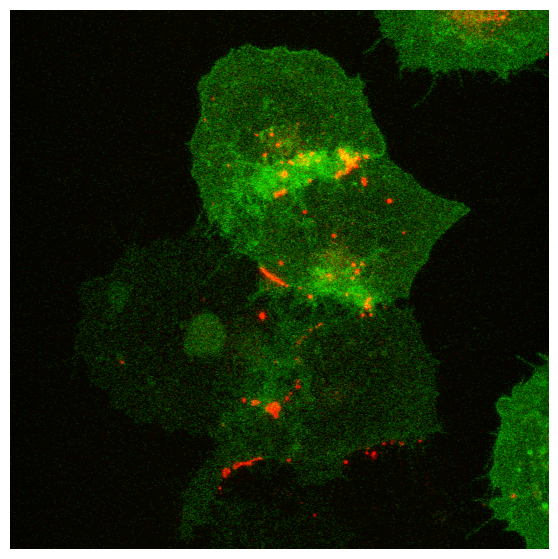

In [50]:
# image file reading and writing
from aicsimageio import AICSImage

# method for rescaling pixel values of an image
from skimage.exposure import rescale_intensity

raw_data = AICSImage('/allen/aics/assay-dev/users/Sandi/pair-up/anthonya/live-cells/modifeid.tiff')

# read the first frame and get the max z-projection
example_frame = np.max(
    raw_data.get_image_data(dimension_order_out="CZYX", T=0),
    axis = 1
)

# plot image using np.stack to create a 3-channel RGB image
# we also use rescale_intensity to adjust the image values to between [0, 1]
plt.figure(figsize=(7,7))
plt.imshow(
    rescale_intensity(
        np.stack([example_frame[0], example_frame[1], np.zeros_like(example_frame[0])], axis=-1),
    out_range=(0, 1))
)
plt.axis('off')
plt.show()

# Image Registration for Drift Correction

The timelapse data here experiences camera jitter/drift, which can impact tracking results and analyis

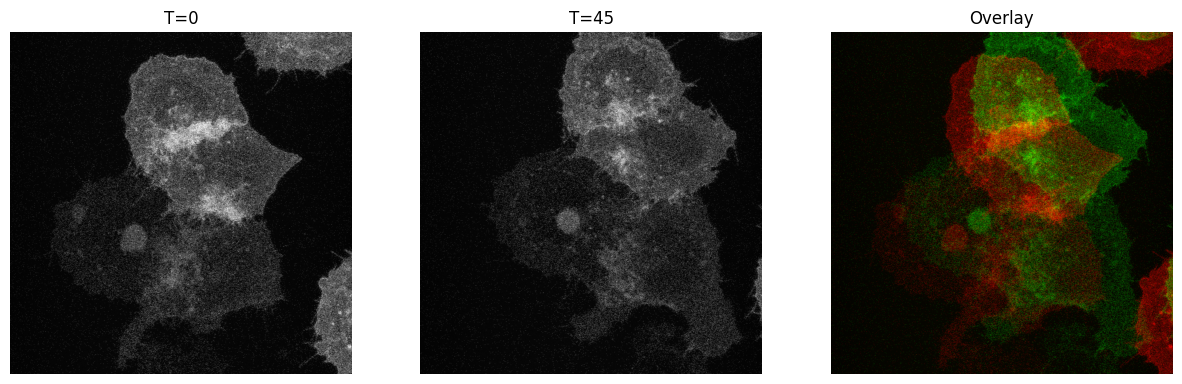

In [51]:
frame_t0 = np.max(raw_data.get_image_data(dimension_order_out="ZYX", C=1, T=0), axis=0)
frame_t45 = np.max(raw_data.get_image_data(dimension_order_out="ZYX", C=1, T=45), axis=0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(frame_t0, cmap='gray')
ax[0].axis('off')
ax[0].set_title('T=0')
ax[1].imshow(frame_t45, cmap='gray')
ax[1].axis('off')
ax[1].set_title('T=45')
ax[2].imshow(
    rescale_intensity(
        np.stack(
            [frame_t0, frame_t45, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[2].axis('off')
ax[2].set_title('Overlay')
plt.show()

We can attempt to correct this by using image registration. Since the cells change over time we will use the `phase_cross_correlation` method in `skimage.registration` to compute a translation that aligns both frames.

First we segment the green channels of both images. This is because the method lets us use a binary mask to narrow the region of the image used to calculate the image overlap, making results more accurate and consistent. For this we will use a simple image threshold using Ostu's method, which is also provided in `skimage.filters`

In [52]:
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes

def segment_image(img):
    # basic preprocessing
    p5, p95 = np.percentile(img, (5, 95))
    img = np.clip(img, p5, p95)
    img = rescale_intensity(img, out_range=np.uint8)
    
    #applying gaussian filter to smooth the image and reduce noise
    img = gaussian(img, 11)
    
    # thresholding using otsu's method
    # we reduce the calculated threshold to include dimmer pixels from low-flourescence cells
    threshold = threshold_otsu(img)
    segmentation_mask = img > threshold * 0.25
    
    # segmentation post-processing
    segmentation_mask = remove_small_objects(segmentation_mask, 100)
    segmentation_mask = remove_small_holes(segmentation_mask, 5000)
    
    return segmentation_mask

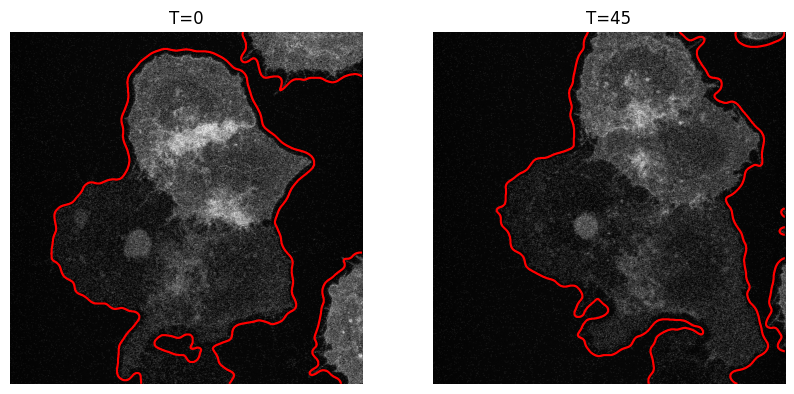

In [53]:
# apply our segmentation function to the frames
mask_t0 = segment_image(frame_t0)
mask_t45 = segment_image(frame_t45)

# plot segmentation results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(frame_t0, cmap='gray')
ax[0].contour(mask_t0, colors='r', levels=[0.5])
ax[0].axis('off')
ax[0].set_title('T=0')
ax[1].imshow(frame_t45, cmap='gray')
ax[1].contour(mask_t45, colors='r', levels=[0.5])
ax[1].axis('off')
ax[1].set_title('T=45')
plt.show()

The plot above shows our segmentation masks outlined in red. While it's not perfect at segmenting the entire cytisol signal this will be good enough to optimize the registration process. We will also be dilating this segmentation to include additional context around the segmented objects.


Now we will write a function to generate segmentations for any two input frames and calculate the shift between them using phase cross correlation. In image registration we call one image the reference image and the other the moving image. The reference image is what we are trying to adjust the moving image to overlap with. In the context of drift correction the reference image should be a frame at a timepoint prior to the moving image.

Our function will return a 2-element array `[dy, dx]`, giving us how many pixels in the y and x axis (respectively) the moving image needs to be aligned to the reference image.

In [54]:
from skimage.registration import phase_cross_correlation
from skimage.morphology import binary_dilation, disk

def calculate_shift(reference, moving, use_mask=True):
    if use_mask:
        # segment the images
        ref_mask = segment_image(reference)
        mov_mask = segment_image(moving)
        
        # dilate the masks to include more context
        ref_mask = binary_dilation(ref_mask, disk(15))
        mov_mask = binary_dilation(mov_mask, disk(15))
        
        # smooth the images to reduce noise
        ref_smooth = gaussian(reference, 3)
        mov_smooth = gaussian(moving, 3)
        
        # calculate the shift
        shift, _, _ = phase_cross_correlation(
            reference_image=ref_smooth, 
            moving_image=mov_smooth, 
            reference_mask=ref_mask, 
            moving_mask=mov_mask
        )
    else:
        # if no mask is given we use the upscale_factor variable to increase precision
        shift, _, _ = phase_cross_correlation(
            reference_image=reference, 
            moving_image=moving,
            upsample_factor=20
        )
        
    return shift

Now we will be taking our alignment parameters and using them to create a transformation matrix. Since a digital image is basically a matrix of numbers, this lets us represent our alignmnet process as a linear algebra operation we can apply to the image. This also means that we can generate a transformation matrix using one set of images and apply it to a seperate set. Fortunately `skimage` can do all the work for us building and applying this transformation matrix.

There are several different types of transformation matrices, but we will be using a Similarity Transform matrix. This transform only allows us to translate, scale, or rotate the the image. In this case we only need to use the translation component.

In [55]:
def apply_shift(image, shift):
    # create a similarity transform object
    tform = SimilarityTransform(translation=shift)
    
    # apply the shift to the image
    shifted_image = warp(image, tform, order=0, preserve_range=True, mode='constant')
    
    return shifted_image

So now let's apply all the code we've developed

Our registration shift is: [ 73. -83.]


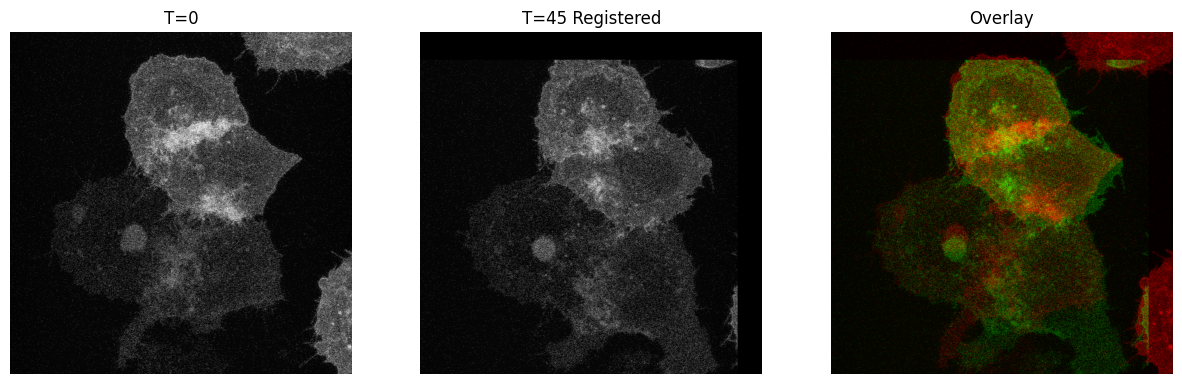

In [56]:
# calculate the shift between the two frames
shift = calculate_shift(frame_t0, frame_t45, use_mask=True)
print(f'Our registration shift is: {shift}')

# apply the shift to the second frame
frame_t45_registered = apply_shift(frame_t45, shift)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(frame_t0, cmap='gray')
ax[0].axis('off')
ax[0].set_title('T=0')
ax[1].imshow(frame_t45_registered, cmap='gray')
ax[1].axis('off')
ax[1].set_title('T=45 Registered')
ax[2].imshow(
    rescale_intensity(
        np.stack(
            [frame_t0, frame_t45_registered, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[2].axis('off')
ax[2].set_title('Overlay')
plt.show()

It should be noted that the further in time your moving frame is from the reference image, the more likely the registration will not be perfect. This is because the cells have chenge in shape to the point that determining an overlap with the initial timepoint becomes difficult.

Our registration shift is: [  76. -188.]


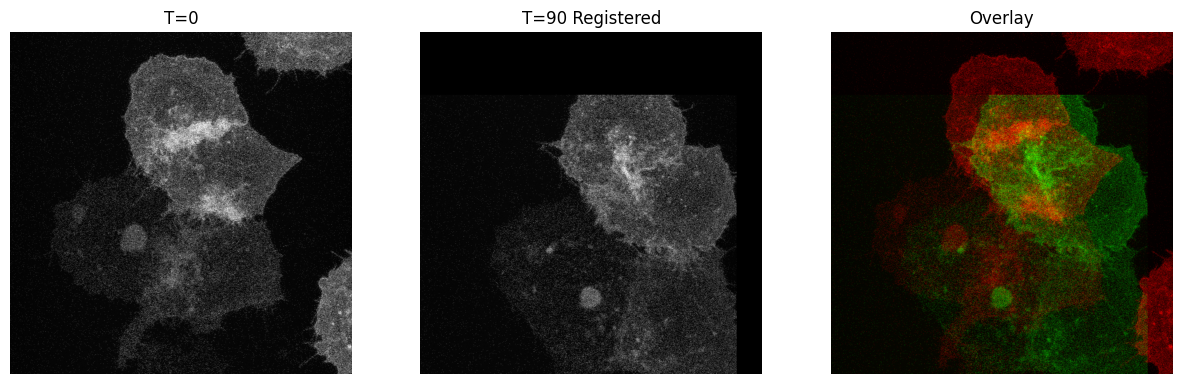

In [57]:
# calculate the shift between the two frames
frame_t90 = np.max(raw_data.get_image_data(dimension_order_out="ZYX", C=1, T=90), axis=0)
shift = calculate_shift(frame_t0, frame_t90, use_mask=True)
print(f'Our registration shift is: {shift}')

# apply the shift to the second frame
frame_t90_registered = apply_shift(frame_t90, shift)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(frame_t0, cmap='gray')
ax[0].axis('off')
ax[0].set_title('T=0')
ax[1].imshow(frame_t90_registered, cmap='gray')
ax[1].axis('off')
ax[1].set_title('T=90 Registered')
ax[2].imshow(
    rescale_intensity(
        np.stack(
            [frame_t0, frame_t90_registered, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[2].axis('off')
ax[2].set_title('Overlay')
plt.show()

Therefore it's a good idea to update your reference image over time ase you correct for drift. Note that the more often you update the reference image the more you will have compounding errors over time, which leads to a balancing act.

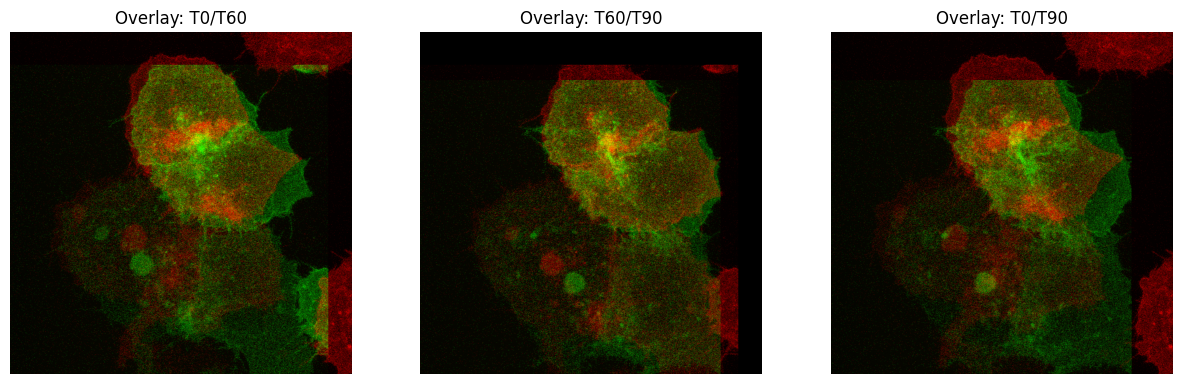

In [58]:
# calculate the shift between the two frames
frame_t60 = np.max(raw_data.get_image_data(dimension_order_out="ZYX", C=1, T=60), axis=0)
frame_t90 = np.max(raw_data.get_image_data(dimension_order_out="ZYX", C=1, T=90), axis=0)

# align frame 60 to frame 0
shift = calculate_shift(frame_t0, frame_t60, use_mask=True)
frame_t60_registered = apply_shift(frame_t60, shift)

# now align frame 90 to the aligned version of frame 60
shift = calculate_shift(frame_t60_registered, frame_t90, use_mask=True)
frame_t90_registered = apply_shift(frame_t90, shift)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(
    rescale_intensity(
        np.stack(
            [frame_t0, frame_t60_registered, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[0].axis('off')
ax[0].set_title('Overlay: T0/T60')

ax[1].imshow(
    rescale_intensity(
        np.stack(
            [frame_t60_registered, frame_t90_registered, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[1].axis('off')
ax[1].set_title('Overlay: T60/T90')

ax[2].imshow(
    rescale_intensity(
        np.stack(
            [frame_t0, frame_t90_registered, np.zeros_like(frame_t0)], 
            axis=-1
        ), 
    out_range=(0, 1))
)
ax[2].axis('off')
ax[2].set_title('Overlay: T0/T90')
plt.show()

Let's take this method and apply it to the entire dataset!

Actually, let's not. Registration is often a computationally demanding process and aligning an entire high-res, 180 timepoint movie can last minutes to hours depending on your hardware. But here's the code used to generate the data we'll use for the rest of the analysis! We will also be collecting the shifts we calculate so the we can apply it to our segmentations.

In [59]:
from tqdm import tqdm

def correct_motion(data, alignment_channel=1, reference_update_rate=60):
    # get the number of frames and the number of channels
    num_frames, num_channels, num_z = data.shape[0], data.shape[1], data.shape[2]
    
    # create an empty array to store the corrected data
    corrected_data = np.zeros(data.shape)
    shifts = np.zeros((num_frames, 2))
    
    # we use the first frame of the data as the original reference frame
    reference_frame = np.max(data.get_image_data('ZYX', T=0, C=alignment_channel), axis=0)
    corrected_data[0] = data.get_image_data('CZYX', T=0)
    
    # loop through each frame
    for t in tqdm(range(1,num_frames)):
        # update the referece frame every reference_update_rate frames
        if t % reference_update_rate == 0:
            reference_frame = np.max(corrected_data[t-1,alignment_channel,...], axis=0)
        
        # get the current frame
        current_frame = np.max(data.get_image_data('ZYX', T=t, C=alignment_channel), axis=0)
        
        # get the alignment shift
        shift = calculate_shift(reference_frame, current_frame, use_mask=True)
        shifts[t] = shift
        
        # apply the shift to the current frame for each channel and z slice
        current_frame_corrected = np.zeros((num_channels, num_z, current_frame.shape[0], current_frame.shape[1]))
        for c in range(num_channels):
            for z in range(num_z):
                current_frame_corrected[c,z] = apply_shift(data.get_image_data('YX', T=t, C=c, ), shift)
                
        corrected_data[t] = current_frame_corrected
                
    return shifts, corrected_data

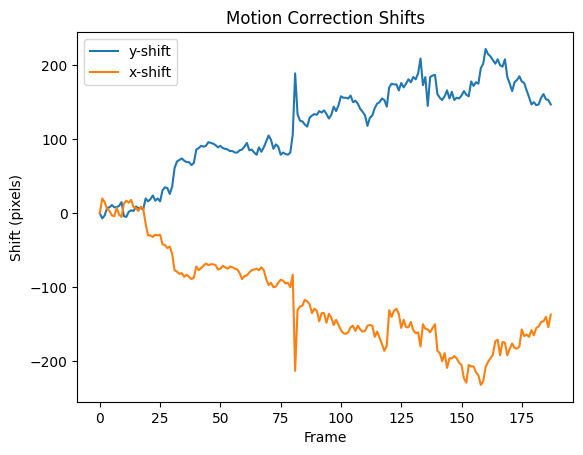

In [60]:
# Set True to run the motion correction process. Otherwise it will load pre-generated results
run_process = False

if run_process:
    # run motion correction
    shifts, corrected_data = correct_motion(raw_data, alignment_channel=1, reference_update_rate=20)
    
    # save the corrected data
    OmeTiffWriter.save(corrected_data, 'results/corrected_data.tiff', dimension_order='TCZYX')
    # reload the corrected data using AICSImage to save memory
    raw_data = AICSImage('results/corrected_data.tiff')

    # save the shifts and plot them
    df_shifts = pd.DataFrame(shifts, columns=['y-shift', 'x-shift'], index=range(0, len(shifts)))
    df_shifts.index.name = 'frame'
    df_shifts.to_csv('results/motion_correction_shifts.csv')
    df_shifts.plot(title='Motion Correction Shifts', ylabel='Shift (pixels)', xlabel='Frame') 
else:
    # insert code to load pre-generated results
    raw_data = AICSImage('results/corrected_data.tiff')
    df_shifts = pd.read_csv('results/motion_correction_shifts.csv', index_col='frame')
    df_shifts.plot(title='Motion Correction Shifts', ylabel='Shift (pixels)', xlabel='Frame') 

There will be instances where you want to apply the same alignment parameters to other data, such as for segmentation masks generated on the un-aligned data. For that we can use the code below to use the translations we calculated and saved above.

In [61]:
def apply_shift_to_data(data, df_shifts):
    # get the number of frames and the number of channels
    num_frames, num_channels, num_z = data.shape[0], data.shape[1], data.shape[2]
    
    # create an empty array to store the corrected data
    corrected_data = np.zeros(data.shape)
    
    # we use the first frame of the data as the original reference frame
    corrected_data[0] = data.get_image_data('CZYX', T=0)
    
    # loop through each frame
    for t in tqdm(range(1,num_frames)):
        # get the current frame
        current_frame = data.get_image_data('CZYX', T=t)
        
        # get the alignment shift
        shift = df_shifts.loc[t, ['y-shift', 'x-shift']].values
        
        # apply the shift to the current frame for each channel and z slice
        current_frame_corrected = np.zeros((num_channels, num_z, current_frame.shape[2], current_frame.shape[3]))
        for c in range(num_channels):
            for z in range(num_z):
                current_frame_corrected[c,z] = apply_shift(current_frame[c,z], shift)
                
        corrected_data[t] = current_frame_corrected
                
    return corrected_data

In [62]:
# memory cleanup
del frame_t0, frame_t45, frame_t45_registered, frame_t90, frame_t90_registered, frame_t60, frame_t60_registered, mask_t0, mask_t45, shift, example_frame,

# Image Segmentation

The segmentation data that we will be using for tracking and analysis was generated with our MegaSeg deep learning model. You will have access to run your data on this model duing the workshop, but here is some example code for using our `aics_segmentation` repo if you wish to try out a non-deep learning appraoch.

In [63]:
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects 
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.measure import label

def segment_aics(img):
    intensity_scaling_param = [8000]
    gaussian_smoothing_sigma = 1

    # intensity normalization
    struct_img = intensity_normalization(img, scaling_param=intensity_scaling_param)

    # smoothing with gaussian filter
    structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)
    
    ## PARAMETERS for this step ##
    s3_param = [[2, 0.06]] # original: [[1, 0.04]], current: [[2, 0.06]]
    ################################

    bw = dot_3d_wrapper(structure_img_smooth, s3_param)
    
    # post-processing
    minArea = 20 # current: 20 
    ################################

    seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1)
    
    out=seg.astype(np.uint8)
    out[out>0]=255
    
    return label(out)

Now let's load our segmentations

In [64]:
perform_alignment = False

if perform_alignment:
    seg_data = AICSImage('/allen/aics/assay-dev/computational/data/PairUp-Workshop/results/anthonya/live-cell-MegaSeg-compiled/MegaSeg.tiff')
    
    seg_data = apply_shift_to_data(seg_data, df_shifts)
    OmeTiffWriter.save(seg_data, 'results/segmented_data.tiff', dimension_order='TCZYX')
    seg_data = AICSImage('results/segmented_data.tiff')
else:
    seg_data = AICSImage('results/segmented_data.tiff')

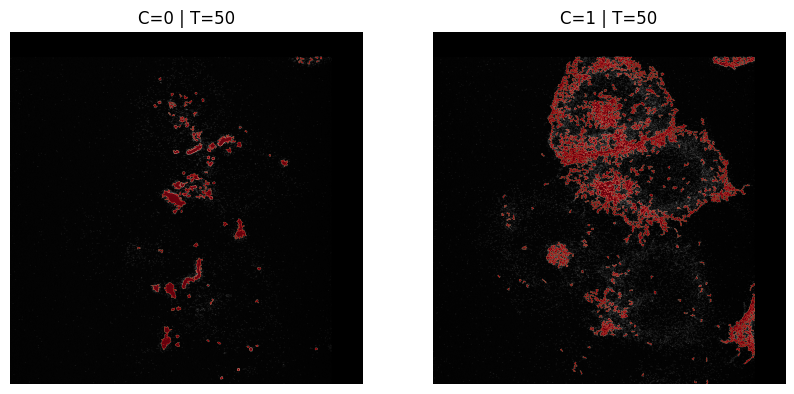

In [65]:
# Choose a timepoint to visualize
timepoint = 50

seg_ch0 = np.max(seg_data.get_image_data('ZYX', T=timepoint, C=0), axis=0) > 250
seg_ch1 = np.max(seg_data.get_image_data('ZYX', T=timepoint, C=1), axis=0) > 250

seg_ch0 = remove_small_objects(seg_ch0, 25) * 250
seg_ch1 = remove_small_objects(seg_ch1, 25) * 250

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.max(raw_data.get_image_data('ZYX', T=timepoint, C=0), axis=0), cmap='gray')
ax[0].imshow(seg_ch0, cmap='Reds', alpha=seg_ch0 / 255)
ax[0].axis('off')
ax[0].set_title(f'C=0 | T={timepoint}')

ax[1].imshow(np.max(raw_data.get_image_data('ZYX', T=timepoint, C=1), axis=0), cmap='gray')
ax[1].imshow(seg_ch1, cmap='Reds', alpha=seg_ch1 / 255)
ax[1].axis('off')
ax[1].set_title(f'C=1 | T={timepoint}')

del seg_ch0, seg_ch1

# 

## Collecting Segmentation/Image Statistics

To utilize these segmentations for our analysis we will be converting this semantic segmentation, where all objects have a single label, to an instance segmentation where each seperate object has its own label to identify it. This can easily be done using the `label` function from `skimage.measure`. This will let us collect statistics for each object, such as position, volume, and average intensity. For this, we will in part be using the `regionprops` function, aslo from `skimage.measure`, which can automatically calculate a lot of these properties from the labeled segmentation we generate.

A full documentation of the properties that `regionprops` collects can be found here: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [66]:
from skimage.measure import regionprops, label

def collect_segmentation_statistics(img_data, seg_data, channel=0, segmentation_threshold=250, size_filter=10):
    num_frames = img_data.shape[0]
    
    # create empty dictionary to store the statistics
    stats = {'frame': [], 'label': [], 'x': [], 'y': [], 'z': [], 'volume': [], 'average intensity': []}
    for tp in tqdm(range(num_frames)):
        # get the image and segmentation data for the current frame
        img = img_data.get_image_data('ZYX', T=tp, C=channel)
        seg = seg_data.get_image_data('ZYX', T=tp, C=channel)
        
        # threshold the segmentation, remove small objects, and label individual regions
        seg = label(remove_small_objects(seg > segmentation_threshold, size_filter))
        
        # get the region properties of the segmentation
        regions = regionprops(label_image=seg, intensity_image=img)
        
        # loop through each region and collect statistics
        for region in regions:
            if region.area > size_filter:
                stats['frame'].append(tp)
                stats['label'].append(region.label)
                stats['x'].append(region.centroid[2])
                stats['y'].append(region.centroid[1])
                stats['z'].append(region.centroid[0])
                stats['volume'].append(region.area)
                stats['average intensity'].append(region.intensity_mean)
                
    return pd.DataFrame(stats)

In [67]:
df_statistics = collect_segmentation_statistics(raw_data, seg_data, channel=0, segmentation_threshold=250, size_filter=25)

# show the first 5 rows of the statistics dataframe
df_statistics.head()

100%|██████████| 188/188 [00:20<00:00,  9.17it/s]


frame  label           x          y         z  volume  average intensity
0      0      1  886.782202  15.300983  0.972755  6203.0        1546.460422
1      0      2  969.164706   6.976471  0.258824    85.0         968.670588
2      0      3  819.572581  11.080645  1.112903   124.0         898.185484
3      0      4  905.737705  34.344262  0.327869    61.0        1119.196721
4      0      5  933.923077  36.230769  1.000000    26.0         842.153846

array([[<Axes: title={'center': 'volume'}>]], dtype=object)

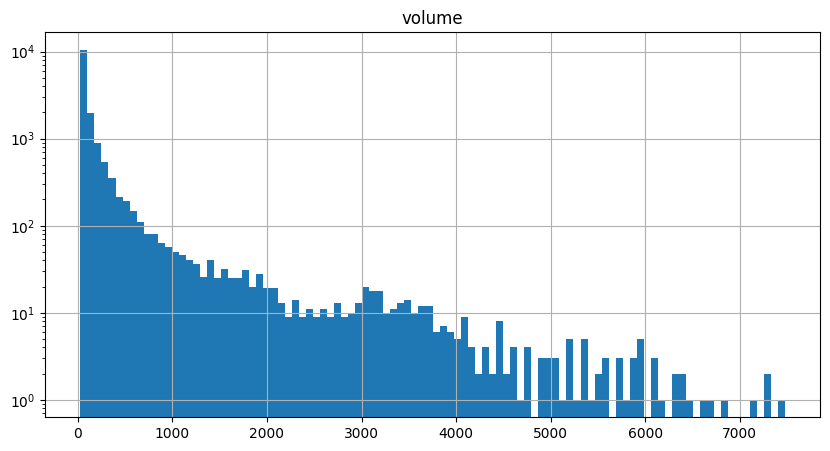

In [68]:
df_statistics.hist(column='volume', bins=100, figsize=(10, 5), log=True)

# Tracking Particles with Trackpy

To demonstrate particle tracking with this data we will use `Trackpy`, which is a simple but easy to use particle tracking package. Unlike more advanced tracking methods Trackpy only looks for the closest object within a predefined range around the particle's previous position, which isn't ideal for where the segmented objects are densely packed together and/or moving fast. But it has several easy-to-use tools and tutorials which serve to introduce the basic concepts and applications of particle tracking.

Full documentation and tutorials: http://soft-matter.github.io/trackpy/v0.6.4/index.html

First we use `trackpy.link()` to use our previously collected data to track the trajectories of particles. Here we can define the search radius for matching particles with `search_range`, as well for how many frames a particle might be missing due to signal dimness or segmentation errors with `memory`.

In [84]:
import trackpy

tracks = trackpy.link(
    f = df_statistics,
    search_range=15,
    pos_columns=['x', 'y', 'z'],
    t_column='frame',
    memory=1,
)

Frame 187: 59 trajectories present.


Let's graph the particle trajectories trackpy found.

Found 6281 tracks in the dataset


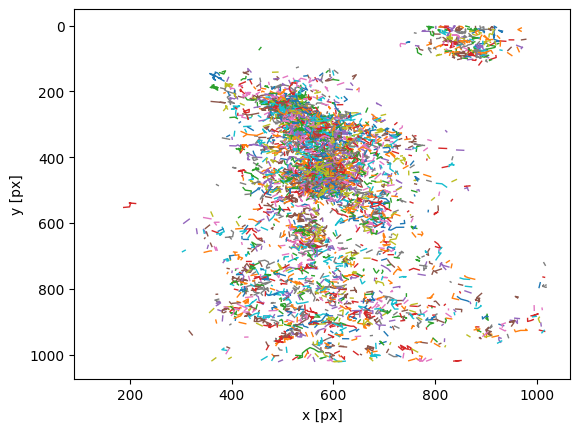

In [85]:
num_tracks = len(tracks['particle'].unique())
print(f'Found {num_tracks} tracks in the dataset')

ax = trackpy.plot_traj(tracks)
plt.show()

Right now our tracking results are dominated by very short trajectories. These could either be noise that was segmented in the image, or very small, short lived particles. We could go back and increase the size threshold when colecting our segmentation statistics, but for now we can clean up our data by filtering out trajectories beneath a certain length using `trackpy.filter_stubs()`

Found 214 tracks in the dataset


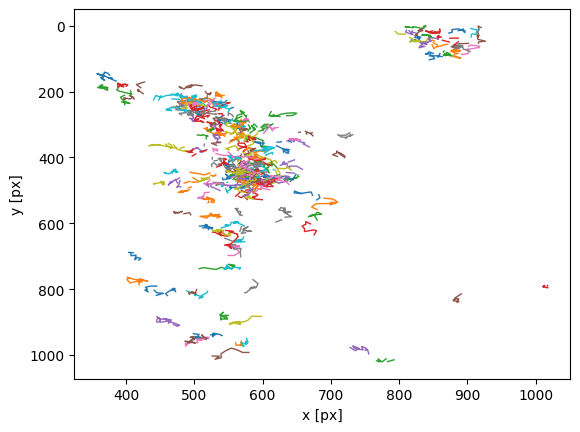

In [86]:
tracks_filtered = trackpy.filter_stubs(tracks, threshold=10)
relabel = {val: idx for idx, val in enumerate(tracks_filtered['particle'].unique())}
tracks_filtered['particle'] = tracks_filtered['particle'].map(relabel)

num_tracks = len(tracks_filtered['particle'].unique())
print(f'Found {num_tracks} tracks in the dataset')

ax = trackpy.plot_traj(tracks_filtered)
plt.show()

In [87]:
tracks_filtered.index = range(0, len(tracks_filtered))
tracks_filtered.index.name = 'object_number'
tracks_filtered.head()

frame  label           x           y         z  volume  \
object_number                                                           
0                  0      1  886.782202   15.300983  0.972755  6203.0   
1                  0     62  679.602520  557.734250  2.557847   873.0   
2                  0     83  820.346939    1.326531  2.122449    49.0   
3                  0     86  874.368932   38.116505  2.631068   103.0   
4                  0     88  860.944444   51.080247  2.753086   162.0   

               average intensity  particle  
object_number                               
0                    1546.460422         0  
1                    2132.008018         1  
2                    1019.285714         2  
3                    1177.203883         3  
4                    1006.901235         4

Here we add some additional statistics that we can compute for our tracks using trackpy.

`Proximity:` the distance in pixels to the particle's nearest neighbor

`Cluster:` a clustering of particles in each frame, uncluding the cluster size

In [ ]:
tracks_filtered['proximity'] = trackpy.proximity(tracks_filtered, pos_columns=['x', 'y', 'z'])['proximity'].values
tracks_filtered = trackpy.static.cluster(tracks_filtered, separation=100, pos_columns=['x', 'y', 'z'], t_column='frame')

tracks_filtered.head()

# Particle Analysis

Here are a few pieces of example code 

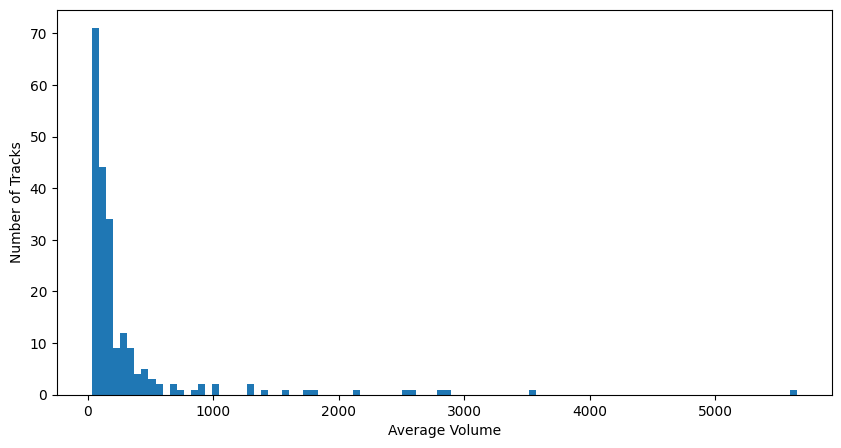

In [88]:
average_size = tracks_filtered.groupby('particle')['volume'].mean()

plt.figure(figsize=(10, 5))
plt.hist(average_size, bins=100)
plt.xlabel('Average Volume')
plt.ylabel('Number of Tracks')
plt.show()

<Axes: xlabel='volume', ylabel='proximity'>

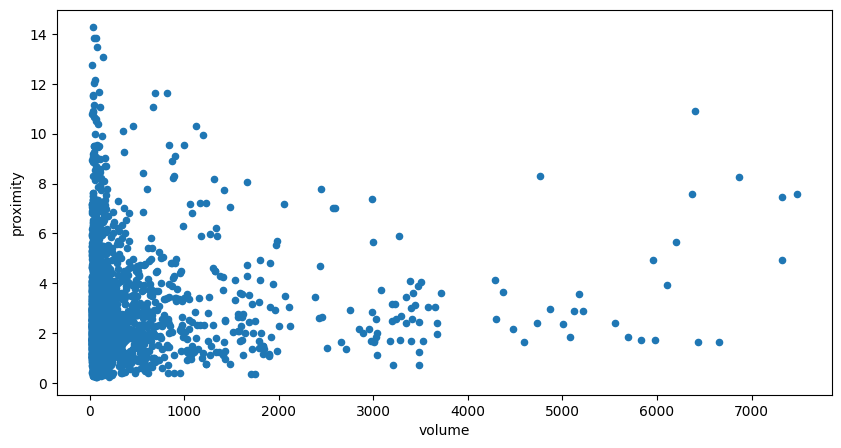

In [89]:


tracks_filtered.plot.scatter(x='volume', y='proximity', figsize=(10, 5))

In [91]:
tracks_filtered.head()

frame  label           x           y         z  volume  \
object_number                                                           
0                  0      1  886.782202   15.300983  0.972755  6203.0   
1                  0     62  679.602520  557.734250  2.557847   873.0   
2                  0     83  820.346939    1.326531  2.122449    49.0   
3                  0     86  874.368932   38.116505  2.631068   103.0   
4                  0     88  860.944444   51.080247  2.753086   162.0   

               average intensity  particle  proximity  cluster  cluster_size  
object_number                                                                 
0                    1546.460422         0   5.645575        3             6  
1                    2132.008018         1   8.905868        1             1  
2                    1019.285714         2   2.329547        3             6  
3                    1177.203883         3  11.658060        3             6  
4                    1006.901235         4   7.351812        3             6

<Axes: xlabel='particle', ylabel='frame'>

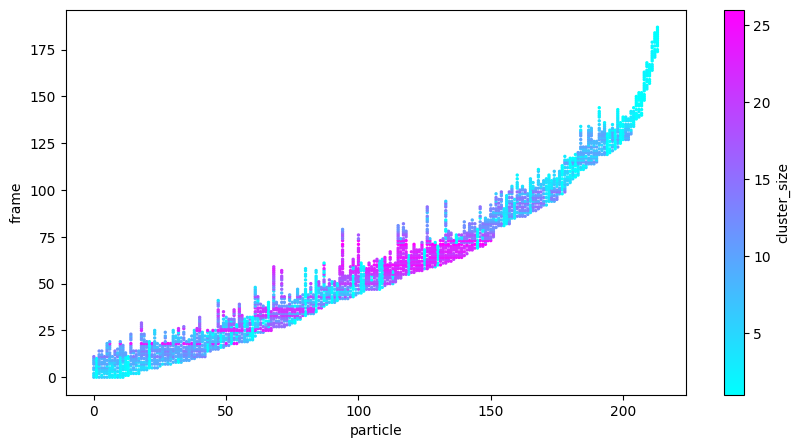

In [92]:
tracks_filtered.plot.scatter(x='particle', y='frame', c='cluster_size', colormap='cool', figsize=(10, 5), s=2)

array([[<Axes: title={'center': 'proximity'}>]], dtype=object)

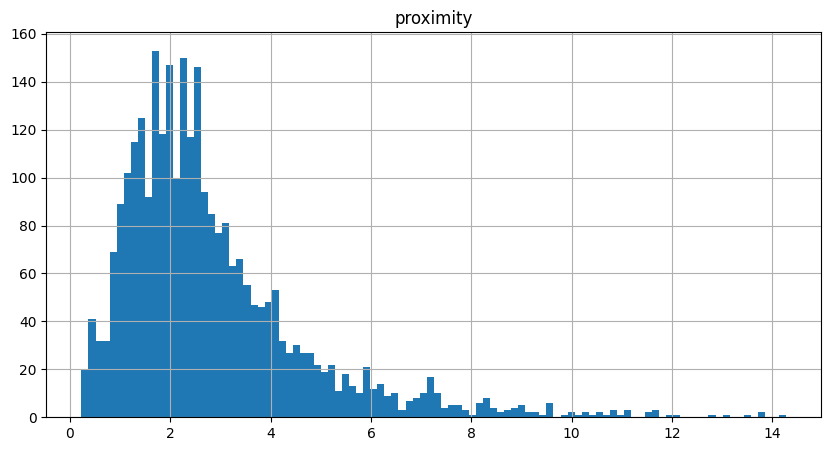

In [93]:
tracks_filtered.hist(column='proximity', bins=100, figsize=(10, 5))

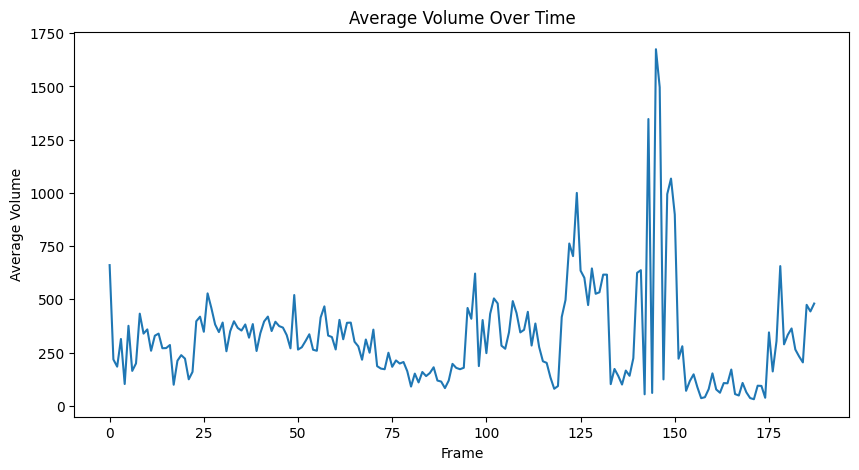

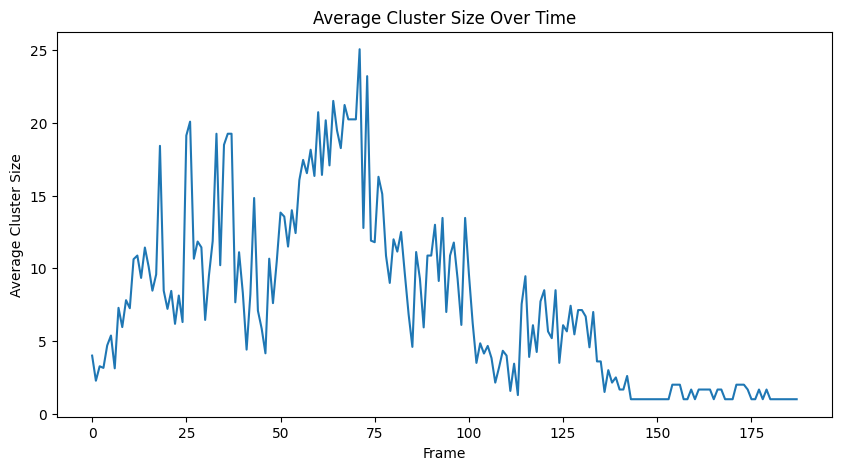

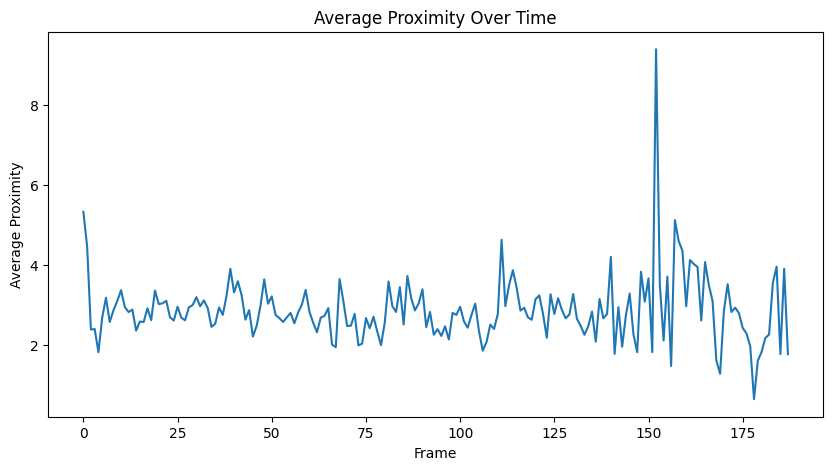

In [94]:
frames = tracks_filtered['frame'].unique()

average_volume = []
average_cluster_size = []
average_proximity = []
for frame in tracks_filtered.groupby('frame'):
    average_volume.append(frame[1]['volume'].mean())
    average_cluster_size.append(frame[1]['cluster_size'].mean())
    average_proximity.append(frame[1]['proximity'].mean())
    
plt.figure(figsize=(10, 5))
plt.plot(frames, average_volume, label='Average Volume')
plt.xlabel('Frame')
plt.ylabel('Average Volume')
plt.title('Average Volume Over Time')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(frames, average_cluster_size, label='Average Cluster Size')
plt.xlabel('Frame')
plt.ylabel('Average Cluster Size')
plt.title('Average Cluster Size Over Time')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(frames, average_proximity, label='Average Proximity')
plt.xlabel('Frame')
plt.ylabel('Average Proximity')
plt.title('Average Proximity Over Time')
plt.show()
    